In [1]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.20.1-py3-none-any.whl (4.4 MB)
  Using cached huggingface_hub-0.8.1-py3-none-any.whl (101 kB)
  Using cached PyYAML-6.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (596 kB)
  Using cached tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.6 MB)
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 35.2 MB/s 


In [80]:
#huggingface libraries 
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AdamW
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset, TensorDataset

#random libraries
from tqdm import tqdm 
import pandas as pd
import numpy as np
import os
import gc
import random

#viz
import matplotlib.pyplot as plt
import seaborn as sns

# set a seed value
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score,precision_score,recall_score,precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")


print(torch.__version__)

1.11.0+cu113


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
if device.type == 'cuda':
  path = 'sample_data/'
else:
  path = 'contradictory-my-dear-watson/'


# EDA

In [8]:
df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

In [9]:
df_train.shape,df_test.shape

((12120, 6), (5195, 5))

In [10]:
df_train.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [11]:
df_test.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

In [12]:
df_train.duplicated().sum(),df_test.duplicated().sum()

(0, 0)

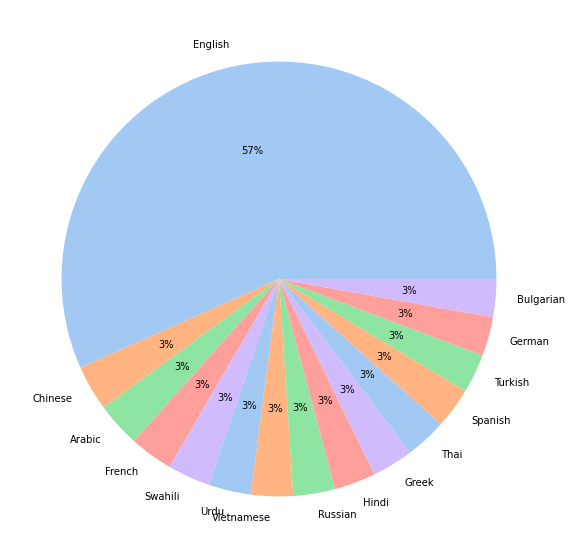

In [84]:
language = (df_train['language'].value_counts()/len(df_train))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
colors = sns.color_palette('pastel')[0:5]
plt.pie(language,labels = language.index,colors = colors, autopct='%.0f%%')
plt.show()

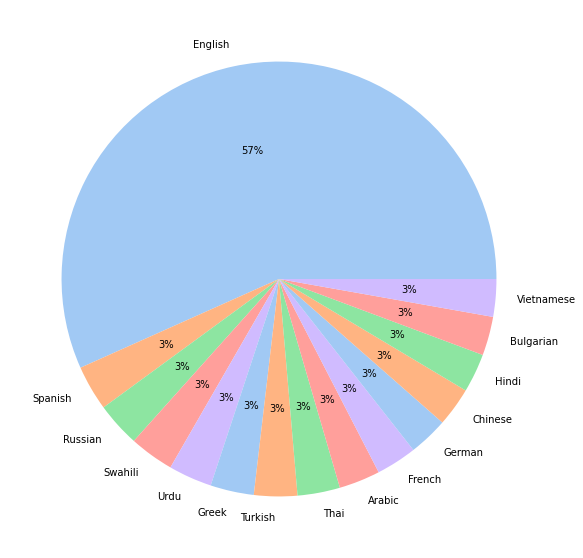

In [86]:
language = (df_test['language'].value_counts()/len(df_test))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
colors = sns.color_palette('pastel')[0:5]
plt.pie(language,labels = language.index,colors = colors, autopct='%.0f%%')
plt.show()

# Preprocessing

In [13]:
|from transformers import TFAutoModel, AutoTokenizer

In [15]:
#model_name = 'bert-base-multilingual-uncased'
#model_name = 'xlm-roberta-base'
model_name = 'joeddav/xlm-roberta-large-xnli' 
batch_size = 5
MAX_LENGTH = 256
NUM_EPOCHS = 2
L_RATE = 1e-5
NUM_CORES = os.cpu_count()
NUM_CORES

2

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [17]:
def preprocess(data1, tokenizer):
    kwargs = { 'truncation': True,
    'max_length': MAX_LENGTH,
    'padding': 'max_length',
     'return_attention_mask': True, 
    'return_token_type_ids': True     
    }
    data = list(zip(data1['premise'], data1['hypothesis']))
    tokenized = tokenizer.batch_encode_plus(data,**kwargs)
    input_ids = torch.LongTensor(tokenized.input_ids)
    attention_masks = torch.LongTensor(tokenized.attention_mask)
    token_type_ids = torch.LongTensor(tokenized.token_type_ids)
    return input_ids, attention_masks, token_type_ids

In [18]:
n = len(df_train)
idx = np.array(range(n))
train_idx = np.random.choice(range(n),size = int(n*0.8),replace = False)
valid_idx = idx[np.isin(idx,train_idx)==False]
train_df = df_train.iloc[train_idx].reset_index(drop = True)
valid_df = df_train.iloc[valid_idx].reset_index(drop = True)

In [19]:
input_ids, attention_masks, token_type_ids = preprocess(train_df,tokenizer)
labels = torch.Tensor(train_df['label']).reshape(-1, 1)
train_dataset_final = TensorDataset(input_ids, attention_masks, token_type_ids,labels)
train_dataloader = DataLoader(train_dataset_final, sampler=RandomSampler(train_dataset_final), batch_size=batch_size)
train_dataset_final

In [20]:
print(len(train_dataloader))

1940


In [30]:
input_ids_test, attention_masks_test, token_type_ids_test = preprocess(valid_df,tokenizer)
labels = torch.Tensor(valid_df['label']).reshape(-1, 1)
test_dataset_final = TensorDataset(input_ids_test, attention_masks_test, token_type_ids_test,labels)
test_dataloader = DataLoader(test_dataset_final, sampler=SequentialSampler(test_dataset_final), batch_size=batch_size)
len(test_dataloader)

485

# Model

In [22]:
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3, output_hidden_states=False, output_attentions=False,problem_type="multi_label_classification")
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
     

In [23]:
batch = next(iter(train_dataloader))
b_input_ids = batch[0].to(device)
b_input_mask = batch[1].to(device)
b_token_type_ids = batch[2].to(device)
b_labels = torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device)

In [24]:
outputs = model(b_input_ids, 
                token_type_ids=b_token_type_ids, 
                attention_mask=b_input_mask,
                labels=b_labels)


# Training

In [25]:
optimizer = AdamW(model.parameters(),
              lr = L_RATE, 
              eps = 1e-8
            )

In [26]:
gc.collect()

139

In [27]:
seed_val = 1024

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [28]:
for epoch in range(NUM_EPOCHS):
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss=0
    
    for i,batch in tqdm(enumerate(train_dataloader)):
        model.zero_grad()
        input_ids, attention_masks, token_type_ids, labels=(batch[0].to(device), 
                                                            batch[1].to(device), 
                                                            batch[2].to(device), 
                                                            torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device))
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks, labels=labels)
        loss=outputs[0]
        if i%10==0:
            print(f'loss of batch {i}: {loss}')
        total_train_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

        optimizer.step()
    print(f'total loss of epoch {epoch}: {total_train_loss}')
    gc.collect()

0it [00:00, ?it/s]

loss of batch 0: 1.8962898254394531


10it [00:08,  1.24it/s]

loss of batch 10: 0.7521686553955078


20it [00:16,  1.23it/s]

loss of batch 20: 0.5961138606071472


30it [00:24,  1.23it/s]

loss of batch 30: 0.6649144887924194


40it [00:32,  1.22it/s]

loss of batch 40: 0.6074669361114502


50it [00:40,  1.21it/s]

loss of batch 50: 0.40875980257987976


60it [00:48,  1.21it/s]

loss of batch 60: 0.4834711253643036


70it [00:57,  1.20it/s]

loss of batch 70: 0.37331488728523254


80it [01:05,  1.19it/s]

loss of batch 80: 0.34946349263191223


90it [01:14,  1.18it/s]

loss of batch 90: 0.6014105081558228


100it [01:22,  1.18it/s]

loss of batch 100: 0.12395752221345901


110it [01:31,  1.17it/s]

loss of batch 110: 0.18489758670330048


120it [01:39,  1.16it/s]

loss of batch 120: 0.06570688635110855


130it [01:48,  1.15it/s]

loss of batch 130: 0.1278567612171173


140it [01:56,  1.15it/s]

loss of batch 140: 0.1015084907412529


150it [02:05,  1.15it/s]

loss of batch 150: 0.9896600246429443


160it [02:14,  1.16it/s]

loss of batch 160: 0.040501780807971954


170it [02:22,  1.16it/s]

loss of batch 170: 0.0334196463227272


180it [02:31,  1.17it/s]

loss of batch 180: 0.022387469187378883


190it [02:40,  1.17it/s]

loss of batch 190: 0.016789430752396584


200it [02:48,  1.17it/s]

loss of batch 200: 0.013580112718045712


210it [02:57,  1.16it/s]

loss of batch 210: 0.011051090434193611


220it [03:05,  1.16it/s]

loss of batch 220: 0.49367284774780273


230it [03:14,  1.16it/s]

loss of batch 230: 0.4042479693889618


240it [03:23,  1.16it/s]

loss of batch 240: 0.01656629517674446


250it [03:31,  1.16it/s]

loss of batch 250: 0.010462497361004353


260it [03:40,  1.16it/s]

loss of batch 260: 0.011983003467321396


270it [03:49,  1.16it/s]

loss of batch 270: 0.2949511408805847


280it [03:57,  1.16it/s]

loss of batch 280: 0.008589454926550388


290it [04:06,  1.16it/s]

loss of batch 290: 0.7668440341949463


300it [04:15,  1.16it/s]

loss of batch 300: 0.008004672825336456


310it [04:23,  1.16it/s]

loss of batch 310: 0.17475850880146027


320it [04:32,  1.16it/s]

loss of batch 320: 0.6692917346954346


330it [04:40,  1.16it/s]

loss of batch 330: 0.6988270282745361


340it [04:49,  1.16it/s]

loss of batch 340: 0.0067880842834711075


350it [04:58,  1.16it/s]

loss of batch 350: 0.6957125067710876


360it [05:06,  1.16it/s]

loss of batch 360: 0.4889375567436218


370it [05:15,  1.16it/s]

loss of batch 370: 0.5052454471588135


380it [05:23,  1.16it/s]

loss of batch 380: 0.008716573938727379


390it [05:32,  1.16it/s]

loss of batch 390: 0.06671832501888275


400it [05:41,  1.16it/s]

loss of batch 400: 0.5602557063102722


410it [05:49,  1.16it/s]

loss of batch 410: 0.6614838242530823


420it [05:58,  1.16it/s]

loss of batch 420: 0.006271267309784889


430it [06:07,  1.16it/s]

loss of batch 430: 0.006380801554769278


440it [06:15,  1.16it/s]

loss of batch 440: 0.8079179525375366


450it [06:24,  1.16it/s]

loss of batch 450: 0.010700134560465813


460it [06:32,  1.15it/s]

loss of batch 460: 0.014146183617413044


470it [06:41,  1.16it/s]

loss of batch 470: 0.011057602241635323


480it [06:50,  1.16it/s]

loss of batch 480: 0.1927390992641449


490it [06:58,  1.16it/s]

loss of batch 490: 0.6526511907577515


500it [07:07,  1.16it/s]

loss of batch 500: 0.008927530609071255


510it [07:16,  1.16it/s]

loss of batch 510: 0.5976487398147583


520it [07:24,  1.16it/s]

loss of batch 520: 0.008103030733764172


530it [07:33,  1.16it/s]

loss of batch 530: 0.008510664105415344


540it [07:42,  1.16it/s]

loss of batch 540: 0.36077752709388733


550it [07:50,  1.16it/s]

loss of batch 550: 0.4087465703487396


560it [07:59,  1.16it/s]

loss of batch 560: 0.010098698548972607


570it [08:07,  1.16it/s]

loss of batch 570: 0.18954648077487946


580it [08:16,  1.16it/s]

loss of batch 580: 0.18247850239276886


590it [08:25,  1.16it/s]

loss of batch 590: 0.023476136848330498


600it [08:33,  1.16it/s]

loss of batch 600: 0.015573627315461636


610it [08:42,  1.16it/s]

loss of batch 610: 0.42699292302131653


620it [08:51,  1.16it/s]

loss of batch 620: 0.6275047659873962


630it [08:59,  1.16it/s]

loss of batch 630: 0.6178527474403381


640it [09:08,  1.16it/s]

loss of batch 640: 0.013912061229348183


650it [09:17,  1.16it/s]

loss of batch 650: 0.010033180005848408


660it [09:25,  1.16it/s]

loss of batch 660: 0.0072227050550282


670it [09:34,  1.16it/s]

loss of batch 670: 0.029424572363495827


680it [09:42,  1.16it/s]

loss of batch 680: 0.5509217977523804


690it [09:51,  1.16it/s]

loss of batch 690: 0.6798191070556641


700it [10:00,  1.16it/s]

loss of batch 700: 0.054367419332265854


710it [10:08,  1.16it/s]

loss of batch 710: 0.5083645582199097


720it [10:17,  1.16it/s]

loss of batch 720: 0.010241858661174774


730it [10:26,  1.16it/s]

loss of batch 730: 0.015354582108557224


740it [10:34,  1.16it/s]

loss of batch 740: 1.2176153659820557


750it [10:43,  1.16it/s]

loss of batch 750: 0.6403562426567078


760it [10:52,  1.16it/s]

loss of batch 760: 0.035521626472473145


770it [11:00,  1.16it/s]

loss of batch 770: 1.1035304069519043


780it [11:09,  1.16it/s]

loss of batch 780: 0.010425846092402935


790it [11:17,  1.16it/s]

loss of batch 790: 0.010260258801281452


800it [11:26,  1.16it/s]

loss of batch 800: 0.00653835479170084


810it [11:35,  1.16it/s]

loss of batch 810: 1.3280181884765625


820it [11:43,  1.16it/s]

loss of batch 820: 0.6283406615257263


830it [11:52,  1.16it/s]

loss of batch 830: 0.006701062433421612


840it [12:01,  1.16it/s]

loss of batch 840: 0.028491297736763954


850it [12:09,  1.16it/s]

loss of batch 850: 0.006604762282222509


860it [12:18,  1.16it/s]

loss of batch 860: 0.5674833655357361


870it [12:27,  1.16it/s]

loss of batch 870: 1.1074068546295166


880it [12:35,  1.16it/s]

loss of batch 880: 0.01294430997222662


890it [12:44,  1.16it/s]

loss of batch 890: 0.00454467860981822


900it [12:52,  1.16it/s]

loss of batch 900: 0.3871817886829376


910it [13:01,  1.16it/s]

loss of batch 910: 0.005112805869430304


920it [13:10,  1.16it/s]

loss of batch 920: 1.423309326171875


930it [13:18,  1.16it/s]

loss of batch 930: 0.6417949795722961


940it [13:27,  1.16it/s]

loss of batch 940: 0.00897848978638649


950it [13:36,  1.16it/s]

loss of batch 950: 0.009401449002325535


960it [13:44,  1.16it/s]

loss of batch 960: 0.008466074243187904


970it [13:53,  1.16it/s]

loss of batch 970: 0.006702491082251072


980it [14:01,  1.16it/s]

loss of batch 980: 0.006461219396442175


990it [14:10,  1.16it/s]

loss of batch 990: 0.6718172430992126


1000it [14:19,  1.16it/s]

loss of batch 1000: 0.004954766482114792


1010it [14:27,  1.16it/s]

loss of batch 1010: 0.007838216610252857


1020it [14:36,  1.16it/s]

loss of batch 1020: 0.005164270754903555


1030it [14:45,  1.16it/s]

loss of batch 1030: 0.005065003409981728


1040it [14:53,  1.16it/s]

loss of batch 1040: 1.079811692237854


1050it [15:02,  1.16it/s]

loss of batch 1050: 0.7484630346298218


1060it [15:11,  1.16it/s]

loss of batch 1060: 1.1576180458068848


1070it [15:19,  1.16it/s]

loss of batch 1070: 0.5288336873054504


1080it [15:28,  1.16it/s]

loss of batch 1080: 0.014678020030260086


1090it [15:37,  1.16it/s]

loss of batch 1090: 0.009334932081401348


1100it [15:45,  1.16it/s]

loss of batch 1100: 0.3589947521686554


1110it [15:54,  1.16it/s]

loss of batch 1110: 0.00552504975348711


1120it [16:02,  1.16it/s]

loss of batch 1120: 0.6731650233268738


1130it [16:11,  1.16it/s]

loss of batch 1130: 0.6540923118591309


1140it [16:20,  1.16it/s]

loss of batch 1140: 0.007711469661444426


1150it [16:28,  1.16it/s]

loss of batch 1150: 0.006315418519079685


1160it [16:37,  1.16it/s]

loss of batch 1160: 0.005934634245932102


1170it [16:46,  1.16it/s]

loss of batch 1170: 0.645540177822113


1180it [16:54,  1.16it/s]

loss of batch 1180: 0.007662792690098286


1190it [17:03,  1.16it/s]

loss of batch 1190: 0.6791618466377258


1200it [17:12,  1.16it/s]

loss of batch 1200: 0.010681192390620708


1210it [17:20,  1.16it/s]

loss of batch 1210: 0.5174713134765625


1220it [17:29,  1.16it/s]

loss of batch 1220: 0.16367371380329132


1230it [17:37,  1.16it/s]

loss of batch 1230: 0.6396217942237854


1240it [17:46,  1.16it/s]

loss of batch 1240: 0.5877729654312134


1250it [17:55,  1.16it/s]

loss of batch 1250: 0.4775272607803345


1260it [18:03,  1.16it/s]

loss of batch 1260: 0.6867132186889648


1270it [18:12,  1.16it/s]

loss of batch 1270: 0.006995630916208029


1280it [18:21,  1.16it/s]

loss of batch 1280: 0.651651918888092


1290it [18:29,  1.16it/s]

loss of batch 1290: 0.018192272633314133


1300it [18:38,  1.16it/s]

loss of batch 1300: 0.6395379900932312


1310it [18:47,  1.16it/s]

loss of batch 1310: 0.4675275981426239


1320it [18:55,  1.16it/s]

loss of batch 1320: 0.009162086062133312


1330it [19:04,  1.16it/s]

loss of batch 1330: 0.06797939538955688


1340it [19:12,  1.16it/s]

loss of batch 1340: 0.007868286222219467


1350it [19:21,  1.16it/s]

loss of batch 1350: 0.009867738001048565


1360it [19:30,  1.16it/s]

loss of batch 1360: 0.6882333755493164


1370it [19:38,  1.16it/s]

loss of batch 1370: 0.03543480485677719


1380it [19:47,  1.16it/s]

loss of batch 1380: 0.6329572200775146


1390it [19:56,  1.16it/s]

loss of batch 1390: 0.0075223916210234165


1400it [20:04,  1.16it/s]

loss of batch 1400: 0.6518908739089966


1410it [20:13,  1.16it/s]

loss of batch 1410: 0.6170777082443237


1420it [20:21,  1.16it/s]

loss of batch 1420: 0.006389935966581106


1430it [20:30,  1.15it/s]

loss of batch 1430: 0.007678413763642311


1440it [20:39,  1.15it/s]

loss of batch 1440: 0.0074581578373909


1450it [20:47,  1.16it/s]

loss of batch 1450: 0.025073295459151268


1460it [20:56,  1.16it/s]

loss of batch 1460: 0.0062538934871554375


1470it [21:05,  1.16it/s]

loss of batch 1470: 0.6273632645606995


1480it [21:13,  1.16it/s]

loss of batch 1480: 0.8969871401786804


1490it [21:22,  1.16it/s]

loss of batch 1490: 0.43166178464889526


1500it [21:31,  1.16it/s]

loss of batch 1500: 0.00594188692048192


1510it [21:39,  1.16it/s]

loss of batch 1510: 0.006570675875991583


1520it [21:48,  1.16it/s]

loss of batch 1520: 0.03892485424876213


1530it [21:56,  1.16it/s]

loss of batch 1530: 0.6940180659294128


1540it [22:05,  1.16it/s]

loss of batch 1540: 1.1672492027282715


1550it [22:14,  1.16it/s]

loss of batch 1550: 0.07302097231149673


1560it [22:22,  1.16it/s]

loss of batch 1560: 0.5105922818183899


1570it [22:31,  1.16it/s]

loss of batch 1570: 0.8660251498222351


1580it [22:40,  1.16it/s]

loss of batch 1580: 0.6037883162498474


1590it [22:48,  1.15it/s]

loss of batch 1590: 0.02836618199944496


1600it [22:57,  1.16it/s]

loss of batch 1600: 0.2892182171344757


1610it [23:06,  1.16it/s]

loss of batch 1610: 0.4744270443916321


1620it [23:14,  1.16it/s]

loss of batch 1620: 0.020351074635982513


1630it [23:23,  1.16it/s]

loss of batch 1630: 0.19885484874248505


1640it [23:32,  1.16it/s]

loss of batch 1640: 0.005828820168972015


1650it [23:40,  1.16it/s]

loss of batch 1650: 1.1679253578186035


1660it [23:49,  1.16it/s]

loss of batch 1660: 0.008887520991265774


1670it [23:57,  1.15it/s]

loss of batch 1670: 0.36289703845977783


1680it [24:06,  1.16it/s]

loss of batch 1680: 0.004779806826263666


1690it [24:15,  1.16it/s]

loss of batch 1690: 0.006126538384705782


1700it [24:23,  1.16it/s]

loss of batch 1700: 0.7072232365608215


1710it [24:32,  1.16it/s]

loss of batch 1710: 0.6268442869186401


1720it [24:41,  1.16it/s]

loss of batch 1720: 0.006220905110239983


1730it [24:49,  1.16it/s]

loss of batch 1730: 0.02000374160706997


1740it [24:58,  1.16it/s]

loss of batch 1740: 0.015214704908430576


1750it [25:07,  1.16it/s]

loss of batch 1750: 0.5831155180931091


1760it [25:15,  1.16it/s]

loss of batch 1760: 1.0661791563034058


1770it [25:24,  1.16it/s]

loss of batch 1770: 0.02648637816309929


1780it [25:32,  1.16it/s]

loss of batch 1780: 0.8365424871444702


1790it [25:41,  1.16it/s]

loss of batch 1790: 0.8531662821769714


1800it [25:50,  1.16it/s]

loss of batch 1800: 0.009978515096008778


1810it [25:58,  1.16it/s]

loss of batch 1810: 0.005735229700803757


1820it [26:07,  1.15it/s]

loss of batch 1820: 0.916202962398529


1830it [26:16,  1.16it/s]

loss of batch 1830: 0.00869446899741888


1840it [26:24,  1.16it/s]

loss of batch 1840: 1.6516132354736328


1850it [26:33,  1.16it/s]

loss of batch 1850: 0.026410911232233047


1860it [26:42,  1.16it/s]

loss of batch 1860: 0.006698459852486849


1870it [26:50,  1.16it/s]

loss of batch 1870: 0.0055046421475708485


1880it [26:59,  1.16it/s]

loss of batch 1880: 0.0064018196426332


1890it [27:07,  1.16it/s]

loss of batch 1890: 0.6645920276641846


1900it [27:16,  1.16it/s]

loss of batch 1900: 0.006045501213520765


1910it [27:25,  1.16it/s]

loss of batch 1910: 0.6404368877410889


1920it [27:33,  1.16it/s]

loss of batch 1920: 0.005549830384552479


1930it [27:42,  1.16it/s]

loss of batch 1930: 0.5984770655632019


1940it [27:50,  1.16it/s]


total loss of epoch 0: 584.2621483588591


0it [00:00, ?it/s]

loss of batch 0: 0.0052291229367256165


10it [00:08,  1.16it/s]

loss of batch 10: 0.035302646458148956


20it [00:17,  1.16it/s]

loss of batch 20: 0.00495689595118165


30it [00:25,  1.16it/s]

loss of batch 30: 0.00582507997751236


40it [00:34,  1.16it/s]

loss of batch 40: 0.006805304903537035


50it [00:43,  1.16it/s]

loss of batch 50: 0.10589292645454407


60it [00:51,  1.16it/s]

loss of batch 60: 0.49517732858657837


70it [01:00,  1.16it/s]

loss of batch 70: 0.0047074719332158566


80it [01:09,  1.16it/s]

loss of batch 80: 0.00442963233217597


90it [01:17,  1.16it/s]

loss of batch 90: 0.0042884461581707


100it [01:26,  1.16it/s]

loss of batch 100: 0.003244587918743491


110it [01:35,  1.16it/s]

loss of batch 110: 1.089208960533142


120it [01:43,  1.16it/s]

loss of batch 120: 0.004286571405827999


130it [01:52,  1.16it/s]

loss of batch 130: 0.6251511573791504


140it [02:00,  1.16it/s]

loss of batch 140: 0.0069086565636098385


150it [02:09,  1.16it/s]

loss of batch 150: 0.11869137734174728


160it [02:18,  1.16it/s]

loss of batch 160: 0.0037970237899571657


170it [02:26,  1.16it/s]

loss of batch 170: 0.00529898377135396


180it [02:35,  1.16it/s]

loss of batch 180: 0.004648448433727026


190it [02:44,  1.16it/s]

loss of batch 190: 0.735085129737854


200it [02:52,  1.16it/s]

loss of batch 200: 0.005156105849891901


210it [03:01,  1.16it/s]

loss of batch 210: 0.5908843874931335


220it [03:10,  1.16it/s]

loss of batch 220: 0.0031784744933247566


230it [03:18,  1.16it/s]

loss of batch 230: 0.003026643069460988


240it [03:27,  1.16it/s]

loss of batch 240: 0.0043972753919661045


250it [03:35,  1.16it/s]

loss of batch 250: 0.005911559332162142


260it [03:44,  1.16it/s]

loss of batch 260: 0.0049703470431268215


270it [03:53,  1.16it/s]

loss of batch 270: 0.6345981955528259


280it [04:01,  1.16it/s]

loss of batch 280: 0.004691881127655506


290it [04:10,  1.16it/s]

loss of batch 290: 0.003825184889137745


300it [04:19,  1.16it/s]

loss of batch 300: 0.003371422179043293


310it [04:27,  1.16it/s]

loss of batch 310: 0.0035930301528424025


320it [04:36,  1.16it/s]

loss of batch 320: 0.0034199373330920935


330it [04:44,  1.16it/s]

loss of batch 330: 0.00406108982861042


340it [04:53,  1.16it/s]

loss of batch 340: 0.004605514463037252


350it [05:02,  1.16it/s]

loss of batch 350: 0.0038578049279749393


360it [05:10,  1.16it/s]

loss of batch 360: 0.005495870485901833


370it [05:19,  1.16it/s]

loss of batch 370: 0.003129560500383377


380it [05:28,  1.16it/s]

loss of batch 380: 0.0042235893197357655


390it [05:36,  1.16it/s]

loss of batch 390: 0.003315584035590291


400it [05:45,  1.16it/s]

loss of batch 400: 0.0031215480994433165


410it [05:54,  1.16it/s]

loss of batch 410: 0.003061488037928939


420it [06:02,  1.16it/s]

loss of batch 420: 0.003874553833156824


430it [06:11,  1.16it/s]

loss of batch 430: 0.5415504574775696


440it [06:20,  1.15it/s]

loss of batch 440: 0.09240192919969559


450it [06:28,  1.16it/s]

loss of batch 450: 0.003983282018452883


460it [06:37,  1.16it/s]

loss of batch 460: 0.0033646938391029835


470it [06:45,  1.16it/s]

loss of batch 470: 0.0052161021158099174


480it [06:54,  1.16it/s]

loss of batch 480: 0.003375878557562828


490it [07:03,  1.16it/s]

loss of batch 490: 0.003448680741712451


500it [07:11,  1.16it/s]

loss of batch 500: 0.00380324712023139


510it [07:20,  1.16it/s]

loss of batch 510: 0.002531747566536069


520it [07:29,  1.16it/s]

loss of batch 520: 0.0027236349415034056


530it [07:37,  1.16it/s]

loss of batch 530: 0.0031692776829004288


540it [07:46,  1.16it/s]

loss of batch 540: 0.0025393411051481962


550it [07:55,  1.16it/s]

loss of batch 550: 0.002796228276565671


560it [08:03,  1.16it/s]

loss of batch 560: 0.003068663412705064


570it [08:12,  1.16it/s]

loss of batch 570: 0.0023140432313084602


580it [08:20,  1.15it/s]

loss of batch 580: 0.0026252842508256435


590it [08:29,  1.16it/s]

loss of batch 590: 0.002776885172352195


600it [08:38,  1.16it/s]

loss of batch 600: 0.0024801900144666433


610it [08:46,  1.16it/s]

loss of batch 610: 0.0030302705708891153


620it [08:55,  1.16it/s]

loss of batch 620: 0.003254240844398737


630it [09:04,  1.16it/s]

loss of batch 630: 0.0033708326518535614


640it [09:12,  1.16it/s]

loss of batch 640: 0.8049832582473755


650it [09:21,  1.16it/s]

loss of batch 650: 0.0029988910537213087


660it [09:30,  1.16it/s]

loss of batch 660: 0.6495758891105652


670it [09:38,  1.16it/s]

loss of batch 670: 1.2899690866470337


680it [09:47,  1.16it/s]

loss of batch 680: 0.6599408984184265


690it [09:55,  1.16it/s]

loss of batch 690: 0.003425226779654622


700it [10:04,  1.16it/s]

loss of batch 700: 0.0027867385651916265


710it [10:13,  1.15it/s]

loss of batch 710: 0.0037216295022517443


720it [10:21,  1.15it/s]

loss of batch 720: 0.6418136954307556


730it [10:30,  1.16it/s]

loss of batch 730: 0.0033810294698923826


740it [10:39,  1.16it/s]

loss of batch 740: 0.6792346835136414


750it [10:47,  1.16it/s]

loss of batch 750: 0.003226503962650895


760it [10:56,  1.16it/s]

loss of batch 760: 0.0028213877230882645


770it [11:05,  1.16it/s]

loss of batch 770: 0.0028986067045480013


780it [11:13,  1.16it/s]

loss of batch 780: 0.5320590734481812


790it [11:22,  1.16it/s]

loss of batch 790: 0.003127445699647069


800it [11:30,  1.16it/s]

loss of batch 800: 0.5246055722236633


810it [11:39,  1.16it/s]

loss of batch 810: 0.0031548438128083944


820it [11:48,  1.16it/s]

loss of batch 820: 0.0023395284079015255


830it [11:56,  1.16it/s]

loss of batch 830: 0.0025066579692065716


840it [12:05,  1.16it/s]

loss of batch 840: 0.0025538757909089327


850it [12:14,  1.16it/s]

loss of batch 850: 0.0023103044368326664


860it [12:22,  1.16it/s]

loss of batch 860: 0.0029523090925067663


870it [12:31,  1.16it/s]

loss of batch 870: 0.12026932835578918


880it [12:40,  1.16it/s]

loss of batch 880: 0.0067762285470962524


890it [12:48,  1.16it/s]

loss of batch 890: 0.0050510223954916


900it [12:57,  1.15it/s]

loss of batch 900: 0.08684171736240387


910it [13:05,  1.16it/s]

loss of batch 910: 0.06845199316740036


920it [13:14,  1.16it/s]

loss of batch 920: 0.003861414035782218


930it [13:23,  1.16it/s]

loss of batch 930: 0.12518364191055298


940it [13:31,  1.16it/s]

loss of batch 940: 0.38570132851600647


950it [13:40,  1.16it/s]

loss of batch 950: 0.2754668593406677


960it [13:49,  1.16it/s]

loss of batch 960: 0.002481186529621482


970it [13:57,  1.16it/s]

loss of batch 970: 0.0029191740322858095


980it [14:06,  1.16it/s]

loss of batch 980: 0.002480573020875454


990it [14:15,  1.16it/s]

loss of batch 990: 1.1130908727645874


1000it [14:23,  1.16it/s]

loss of batch 1000: 0.08538473397493362


1010it [14:32,  1.16it/s]

loss of batch 1010: 0.002511027967557311


1020it [14:40,  1.16it/s]

loss of batch 1020: 1.107822299003601


1030it [14:49,  1.16it/s]

loss of batch 1030: 0.24621397256851196


1040it [14:58,  1.16it/s]

loss of batch 1040: 0.0033990161027759314


1050it [15:06,  1.16it/s]

loss of batch 1050: 0.003682144219055772


1060it [15:15,  1.16it/s]

loss of batch 1060: 0.5447106957435608


1070it [15:24,  1.16it/s]

loss of batch 1070: 0.0039152717217803


1080it [15:32,  1.16it/s]

loss of batch 1080: 0.6236993074417114


1090it [15:41,  1.16it/s]

loss of batch 1090: 0.4257470965385437


1100it [15:50,  1.16it/s]

loss of batch 1100: 0.8557946681976318


1110it [15:58,  1.16it/s]

loss of batch 1110: 0.0037393197417259216


1120it [16:07,  1.16it/s]

loss of batch 1120: 0.5914976000785828


1130it [16:15,  1.16it/s]

loss of batch 1130: 0.003099712310358882


1140it [16:24,  1.16it/s]

loss of batch 1140: 0.5269726514816284


1150it [16:33,  1.16it/s]

loss of batch 1150: 0.003517559263855219


1160it [16:41,  1.16it/s]

loss of batch 1160: 0.019504891708493233


1170it [16:50,  1.16it/s]

loss of batch 1170: 0.5029193162918091


1180it [16:59,  1.16it/s]

loss of batch 1180: 0.002814612351357937


1190it [17:07,  1.16it/s]

loss of batch 1190: 0.724070131778717


1200it [17:16,  1.16it/s]

loss of batch 1200: 0.5296126008033752


1210it [17:24,  1.16it/s]

loss of batch 1210: 0.8950343132019043


1220it [17:33,  1.16it/s]

loss of batch 1220: 0.8073055148124695


1230it [17:42,  1.15it/s]

loss of batch 1230: 0.0028785658068954945


1240it [17:50,  1.15it/s]

loss of batch 1240: 0.0027488362975418568


1250it [17:59,  1.15it/s]

loss of batch 1250: 1.3611857891082764


1260it [18:08,  1.16it/s]

loss of batch 1260: 0.5858463644981384


1270it [18:16,  1.16it/s]

loss of batch 1270: 0.5692450404167175


1280it [18:25,  1.16it/s]

loss of batch 1280: 0.004972766153514385


1290it [18:34,  1.16it/s]

loss of batch 1290: 0.0037577804177999496


1300it [18:42,  1.16it/s]

loss of batch 1300: 0.00294644758105278


1310it [18:51,  1.16it/s]

loss of batch 1310: 0.8085212707519531


1320it [19:00,  1.16it/s]

loss of batch 1320: 0.0031255201902240515


1330it [19:08,  1.16it/s]

loss of batch 1330: 0.0027821878902614117


1340it [19:17,  1.16it/s]

loss of batch 1340: 0.7018024921417236


1350it [19:25,  1.16it/s]

loss of batch 1350: 0.6738181114196777


1360it [19:34,  1.16it/s]

loss of batch 1360: 0.0024281993974000216


1370it [19:43,  1.16it/s]

loss of batch 1370: 0.5041412711143494


1380it [19:51,  1.16it/s]

loss of batch 1380: 0.0027460691053420305


1390it [20:00,  1.16it/s]

loss of batch 1390: 0.0021634078584611416


1400it [20:09,  1.16it/s]

loss of batch 1400: 0.0023126995656639338


1410it [20:17,  1.16it/s]

loss of batch 1410: 0.06793472915887833


1420it [20:26,  1.16it/s]

loss of batch 1420: 0.19999918341636658


1430it [20:35,  1.16it/s]

loss of batch 1430: 0.0020349081605672836


1440it [20:43,  1.16it/s]

loss of batch 1440: 0.0032670078799128532


1450it [20:52,  1.16it/s]

loss of batch 1450: 0.002219422487542033


1460it [21:01,  1.16it/s]

loss of batch 1460: 0.0025071727577596903


1470it [21:09,  1.16it/s]

loss of batch 1470: 0.040832553058862686


1480it [21:18,  1.16it/s]

loss of batch 1480: 0.7219112515449524


1490it [21:26,  1.16it/s]

loss of batch 1490: 0.007595770992338657


1500it [21:35,  1.16it/s]

loss of batch 1500: 0.0036029117181897163


1510it [21:44,  1.16it/s]

loss of batch 1510: 0.009504523128271103


1520it [21:52,  1.16it/s]

loss of batch 1520: 0.00449927756562829


1530it [22:01,  1.16it/s]

loss of batch 1530: 0.223110631108284


1540it [22:10,  1.16it/s]

loss of batch 1540: 0.447498083114624


1550it [22:18,  1.16it/s]

loss of batch 1550: 0.004585192073136568


1560it [22:27,  1.16it/s]

loss of batch 1560: 0.6772656440734863


1570it [22:35,  1.16it/s]

loss of batch 1570: 0.004254799336194992


1580it [22:44,  1.16it/s]

loss of batch 1580: 1.4259198904037476


1590it [22:53,  1.16it/s]

loss of batch 1590: 1.1033356189727783


1600it [23:01,  1.16it/s]

loss of batch 1600: 0.005776928272098303


1610it [23:10,  1.16it/s]

loss of batch 1610: 0.007979695685207844


1620it [23:19,  1.16it/s]

loss of batch 1620: 0.00541506614536047


1630it [23:27,  1.16it/s]

loss of batch 1630: 0.37168246507644653


1640it [23:36,  1.16it/s]

loss of batch 1640: 0.003002698067575693


1650it [23:45,  1.16it/s]

loss of batch 1650: 0.005005432292819023


1660it [23:53,  1.16it/s]

loss of batch 1660: 0.6549947261810303


1670it [24:02,  1.16it/s]

loss of batch 1670: 0.004491268657147884


1680it [24:10,  1.16it/s]

loss of batch 1680: 0.0062845139764249325


1690it [24:19,  1.16it/s]

loss of batch 1690: 0.04477757215499878


1700it [24:28,  1.16it/s]

loss of batch 1700: 0.00938109029084444


1710it [24:36,  1.16it/s]

loss of batch 1710: 0.6928756833076477


1720it [24:45,  1.16it/s]

loss of batch 1720: 0.28589531779289246


1730it [24:54,  1.16it/s]

loss of batch 1730: 0.013942530378699303


1740it [25:02,  1.16it/s]

loss of batch 1740: 0.7689400315284729


1750it [25:11,  1.16it/s]

loss of batch 1750: 0.0030378540977835655


1760it [25:19,  1.16it/s]

loss of batch 1760: 0.8201553821563721


1770it [25:28,  1.16it/s]

loss of batch 1770: 0.003307778388261795


1780it [25:37,  1.16it/s]

loss of batch 1780: 1.5206992626190186


1790it [25:45,  1.16it/s]

loss of batch 1790: 0.023354921489953995


1800it [25:54,  1.16it/s]

loss of batch 1800: 0.7429071068763733


1810it [26:03,  1.16it/s]

loss of batch 1810: 0.0037866949569433928


1820it [26:11,  1.16it/s]

loss of batch 1820: 0.004057117737829685


1830it [26:20,  1.16it/s]

loss of batch 1830: 0.0038063153624534607


1840it [26:29,  1.16it/s]

loss of batch 1840: 0.31941288709640503


1850it [26:37,  1.16it/s]

loss of batch 1850: 0.00422569690272212


1860it [26:46,  1.16it/s]

loss of batch 1860: 0.47342365980148315


1870it [26:54,  1.16it/s]

loss of batch 1870: 0.003661421127617359


1880it [27:03,  1.16it/s]

loss of batch 1880: 0.004162981640547514


1890it [27:12,  1.16it/s]

loss of batch 1890: 0.0028719212859869003


1900it [27:20,  1.16it/s]

loss of batch 1900: 0.0027397419326007366


1910it [27:29,  1.16it/s]

loss of batch 1910: 0.004646416287869215


1920it [27:38,  1.16it/s]

loss of batch 1920: 0.002760844072327018


1930it [27:46,  1.16it/s]

loss of batch 1930: 0.06390700489282608


1940it [27:54,  1.16it/s]

total loss of epoch 1: 400.04079199407715


# Result

In [36]:
stacked_val_labels = []
true_labels = []
model.eval()

torch.set_grad_enabled(False)
total_val_loss = 0

for j, batch in enumerate(test_dataloader):
    input_ids, attention_masks, token_type_ids,labels=(batch[0].to(device), 
                                                        batch[1].to(device), 
                                                        batch[2].to(device),
                                                torch.nn.functional.one_hot(batch[3].to(torch.int64), 3).squeeze(1).float().to(device))
    outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks,labels = labels)

    loss = outputs.loss
    logits = outputs.logits
    true = batch[3]

    val_preds = logits.detach().cpu().numpy()
    total_val_loss += loss.item()
    if j == 0:  # first batch
        stacked_val_preds = val_preds
        true_labels = true

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        true_labels = np.vstack((true_labels, true))
        #stacked_val_preds.extend(val_preds)
    #print(len(stacked_val_preds))

    
            
print(f'\nPrediction complete.\nAverage loss: {total_val_loss/len(test_dataset_final)}')



Prediction complete.
Average loss: 0.06408783759197172


In [37]:
test_preds = np.argmax(stacked_val_preds, axis=1)

In [38]:
test_preds

array([2, 0, 1, ..., 0, 2, 2])

In [52]:
true = true_labels.flatten().astype('int64')

In [71]:
acc = np.sum(test_preds == true)/len(test_preds)
acc

0.8960396039603961

In [60]:
precision, recall, fscore, support = precision_recall_fscore_support(true, test_preds)

In [67]:
score_data = []
for i,(p,r,f,s) in enumerate(zip(precision, recall, fscore, support)):
  score_data.append((i,p,r,f,s))

In [69]:
df = pd.DataFrame(score_data,columns=['label','precision','recall','fscore','support'])

In [70]:
df

,label,precision,recall,fscore,support
0,0,0.904126,0.906326,0.905225,822
1,1,0.874172,0.858257,0.866142,769
2,2,0.907692,0.920768,0.914184,833
